# 컴퓨터비전 AI: mini Kaggle Competition

# Colab

In [ ]:
# 코랩 나눔폰트
!apt-get update -qq
!apt-get install fonts-nanum* -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

In [ ]:
# 코랩 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset

from torchvision.transforms import v2
import torchvision.transforms as transforms
from torchvision.models import resnet18

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

import os
import zipfile
from PIL import Image
from tqdm import tqdm
from glob import glob
import warnings

print(f"PyTorch 버전: {torch.__version__}")
print(f"NumPy 버전: {np.__version__}")

PyTorch 버전: 2.8.0+cu126
NumPy 버전: 2.0.2


In [38]:
# 코랩 폰트
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print("Font name:", font_name)

Font name: NanumGothic


In [39]:
# 로컬폰트
warnings.simplefilter('ignore')

for f in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "NanumGothic" in f:
        path = f
        font_name = fm.FontProperties(fname=f, size=10).get_name()

plt.rcParams['font.family'] = font_name
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

np.set_printoptions(suppress=True, precision=4)

In [40]:
# 장치
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
# 코렙 경로
proj_path_c = "/content/drive/MyDrive/project"

data_path_c = "/content/drive/MyDrive/project/data"
data_zip_c =  os.path.join(data_path_c, "rokey-boot-camp-mini-competition-1.zip")

labels_path_c = os.path.join(data_path_c, "train_data.csv")

train_folder_c = os.path.join(data_path_c, "train_data")
test_folder_c  = os.path.join(data_path_c, "test_data")

- 파일 가져오기

In [42]:
!ls $proj_path_c

data				    project1_5th_2_KFold_251110.ipynb
project1_5th_2_KFold_2511102.ipynb  rokey-boot-camp-mini-competition-1.zip


In [43]:
!unzip $data_zip_c -d $data_path_c

unzip:  cannot find or open /content/drive/MyDrive/project/data/rokey-boot-camp-mini-competition-1.zip, /content/drive/MyDrive/project/data/rokey-boot-camp-mini-competition-1.zip.zip or /content/drive/MyDrive/project/data/rokey-boot-camp-mini-competition-1.zip.ZIP.


In [44]:
!ls $data_path_c

test_data  train_data  train_data.csv


- 파일 구조 확인

In [45]:
!ls $train_folder_c

00000.png  00715.png  01430.png  02145.png  02860.png  03575.png  04290.png
00001.png  00716.png  01431.png  02146.png  02861.png  03576.png  04291.png
00002.png  00717.png  01432.png  02147.png  02862.png  03577.png  04292.png
00003.png  00718.png  01433.png  02148.png  02863.png  03578.png  04293.png
00004.png  00719.png  01434.png  02149.png  02864.png  03579.png  04294.png
00005.png  00720.png  01435.png  02150.png  02865.png  03580.png  04295.png
00006.png  00721.png  01436.png  02151.png  02866.png  03581.png  04296.png
00007.png  00722.png  01437.png  02152.png  02867.png  03582.png  04297.png
00008.png  00723.png  01438.png  02153.png  02868.png  03583.png  04298.png
00009.png  00724.png  01439.png  02154.png  02869.png  03584.png  04299.png
00010.png  00725.png  01440.png  02155.png  02870.png  03585.png  04300.png
00011.png  00726.png  01441.png  02156.png  02871.png  03586.png  04301.png
00012.png  00727.png  01442.png  02157.png  02872.png  03587.png  04302.png
00013.png  0

In [47]:
!ls $test_folder_c

00000.png  01143.png  02286.png  03429.png  04572.png  05715.png  06858.png
00001.png  01144.png  02287.png  03430.png  04573.png  05716.png  06859.png
00002.png  01145.png  02288.png  03431.png  04574.png  05717.png  06860.png
00003.png  01146.png  02289.png  03432.png  04575.png  05718.png  06861.png
00004.png  01147.png  02290.png  03433.png  04576.png  05719.png  06862.png
00005.png  01148.png  02291.png  03434.png  04577.png  05720.png  06863.png
00006.png  01149.png  02292.png  03435.png  04578.png  05721.png  06864.png
00007.png  01150.png  02293.png  03436.png  04579.png  05722.png  06865.png
00008.png  01151.png  02294.png  03437.png  04580.png  05723.png  06866.png
00009.png  01152.png  02295.png  03438.png  04581.png  05724.png  06867.png
00010.png  01153.png  02296.png  03439.png  04582.png  05725.png  06868.png
00011.png  01154.png  02297.png  03440.png  04583.png  05726.png  06869.png
00012.png  01155.png  02298.png  03441.png  04584.png  05727.png  06870.png
00013.png  0

In [48]:
# 첫 10개의 학습 데이터 이름과 label 출력
train_df = pd.read_csv("/content/drive/MyDrive/project/data/train_data.csv")
train_df.head(10)

,label,name
0,1,00000.png
1,5,00001.png
2,1,00002.png
3,6,00003.png
4,3,00004.png
5,9,00005.png
6,7,00006.png
7,4,00007.png
8,5,00008.png
9,8,00009.png


In [49]:
# 각 파일마다 라벨이 무엇인지 나타내는 dictionary 생성
name2label = dict(zip(train_df["name"], train_df["label"]))
print(name2label['03501.png'])

# glob 라이브러리로 훈련데이터에 있는 파일 리스트 출력
data_path = "data"
glob(f"{data_path}/train_data/*.png")

8


[]

# Local

In [ ]:
# 로컬 파일경로
data_path = r"C:\Dev\rokey\AI_basic\trial_class\project\data"

labels_path = os.path.join(data_path, "train_data.csv")

train_folder = os.path.join(data_path, "train_data")
test_folder  = os.path.join(data_path, "test_data")

In [ ]:
print(os.getcwd())
print(os.listdir())
print(os.listdir(data_path))

In [ ]:
# 압축해제
# zip_path = r"rokey-boot-camp-mini-competition-1.zip"

# with zipfile.ZipFile(zip_path, 'r') as z:
#     z.extractall(data_path)

# print(f"압축해제 {data_path}")

In [ ]:
print(os.listdir(train_folder))

In [ ]:
# train 이미지 확인
plt.figure(figsize=(5, 1))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    train_files = os.listdir(train_folder)
    train_files_sample = train_files[:5]
    train_np = np.array([np.array(Image.open(os.path.join(train_folder, f))) for f in train_files_sample])
    img = train_np[i]
    plt.imshow(img)
    ax.axis('off')
plt.show()

In [ ]:
print(os.listdir(test_folder))

['00000.png', '00001.png', '00002.png', '00003.png', '00004.png', '00005.png', '00006.png', '00007.png', '00008.png', '00009.png', '00010.png', '00011.png', '00012.png', '00013.png', '00014.png', '00015.png', '00016.png', '00017.png', '00018.png', '00019.png', '00020.png', '00021.png', '00022.png', '00023.png', '00024.png', '00025.png', '00026.png', '00027.png', '00028.png', '00029.png', '00030.png', '00031.png', '00032.png', '00033.png', '00034.png', '00035.png', '00036.png', '00037.png', '00038.png', '00039.png', '00040.png', '00041.png', '00042.png', '00043.png', '00044.png', '00045.png', '00046.png', '00047.png', '00048.png', '00049.png', '00050.png', '00051.png', '00052.png', '00053.png', '00054.png', '00055.png', '00056.png', '00057.png', '00058.png', '00059.png', '00060.png', '00061.png', '00062.png', '00063.png', '00064.png', '00065.png', '00066.png', '00067.png', '00068.png', '00069.png', '00070.png', '00071.png', '00072.png', '00073.png', '00074.png', '00075.png', '00076.png'

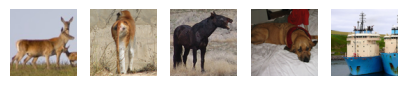

In [ ]:
# test 이미지 확인
plt.figure(figsize=(5, 1))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    test_files = os.listdir(test_folder)
    test_files_sample = test_files[:5]
    test_np = np.array([np.array(Image.open(os.path.join(test_folder, f))) for f in test_files_sample])
    img = test_np[i]
    plt.imshow(img)
    ax.axis('off')
plt.show()

In [ ]:
labels_file = pd.read_csv(labels_path)
labels_file.head(10)

,label,name
0,1,00000.png
1,5,00001.png
2,1,00002.png
3,6,00003.png
4,3,00004.png
5,9,00005.png
6,7,00006.png
7,4,00007.png
8,5,00008.png
9,8,00009.png


# DataLoader

In [50]:
# 변수
class Config:
    def __init__(self):
        self.n_classes=10

        self.resize_n=(96, 96)
        self.rd_crop_size=64
        self.rd_crop_scale=(0.8, 1.0)


        self.rd_flip_rate=0.5
        self.rd_vflip_rate=0.5
        self.rd_rotation_degree=10

        self.brightness=0.2
        self.contrast=0.2
        self.saturation=0.2
        self.hue=0.02

        self.rd_af_degrees=0
        self.rd_af_translate=(0.05, 0.05)

        self.K = 5

        self.test_size = 0.2
        self.val_size = 0.2

        self.batch_size = 128
        self.random_state = 42

        self.input_dim = 3*96*96
        self.hidden_dims = [64, 32, 16]
        self.dropout_rate = 0.3

        self.learning_rate = 0.001
        self.num_epochs = 200

        self.weight_decay = 0.0001
        self.patience = 20
        self.min_delta = 0.001
        self.scheduler_step_size = 30
        self.scheduler_gamma = 0.5

config = Config()

In [51]:
# 커스텀 데이터셋 클래스
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train
        train_df = pd.read_csv(f"{data_path}/train_data.csv")

        self.name2label = dict(zip(train_df["name"], train_df["label"]))

        if self.train:
            self.img_path = glob(f"{data_path}/train_data/*.png")
            self.labels =  [self.name2label[os.path.basename(d)] for d in self.img_path]
        else:
            self.img_path = glob(f"{data_path}/test_data/*.png")

        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, self.labels[index]
        else:
            filename = os.path.basename(self.img_path[index])
            return img, filename

In [52]:
# tensor 변환
tr_transform = v2.Compose([
    v2.RandomResizedCrop(size=config.rd_crop_size, scale=config.rd_crop_scale),
    v2.RandomHorizontalFlip(p=config.rd_flip_rate),
    v2.RandomRotation(degrees=config.rd_rotation_degree)
    v2.ColorJitter(brightness=config.brightness, contrast=config.contrast,
                   saturation=config.saturation, hue=config.hue),
    v2.RandomAffine(degrees=config.rd_af_degree, translate=config.rd_af_translate),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406),
                 std=(0.229, 0.224, 0.225)),
])

vl_transform = transforms.v2.Compose([
    v2.Resize(config.resize_n),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

ts_transform =  transforms.v2.Compose([
    v2.Resize(config.resize_n),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

print('tensor 변환 준비완료')

tensor 변환 준비완료


In [ ]:
# # 데이터 변환 + K-Fold 없음

# # 코렙
# train_data = MyDataset(data_path_c, train=True)
# test_data = MyDataset(data_path_c, train=False, transform=ts_transform)

# 로컬
# train_data = MyDataset(data_path, train=True)
# test_data = MyDataset(data_path, train=False, transform=ts_transform)

# X = np.array([np.array(img) for img, label in train_data])
# y = np.array([label for img, label in train_data])

# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     X, y, test_size=config.test_size, stratify=y, random_state=config.random_state
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_val, y_train_val, test_size=config.val_size,
#     stratify=y_train_val, random_state=config.random_state
# )

# # transform
# X_train_t = torch.stack([tr_transform(Image.fromarray(img)) for img in X_train])
# X_val_t = torch.stack([vl_transform(Image.fromarray(img)) for img in X_val])

# y_train_t = torch.tensor(y_train, dtype=torch.long)
# y_val_t = torch.tensor(y_val, dtype=torch.long)

# # TensorDataset
# Xtr_dataset = TensorDataset(X_train_t, y_train_t)
# Xvl_dataset = TensorDataset(X_val_t, y_val_t)

# # dataloader
# train_loader = torch.utils.data.DataLoader(Xtr_dataset, batch_size=config.batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(Xvl_dataset, batch_size=config.batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=config.batch_size, shuffle=False)

In [53]:
# k-fold 변환

# 데이터 변환
train_data = MyDataset(data_path_c, train=True)
test_data = MyDataset(data_path_c, train=False, transform=ts_transform)

X = np.array([np.array(img) for img, label in train_data])
y = np.array([label for img, label in train_data])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=config.test_size, stratify=y, random_state=config.random_state
)

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_val, y_train_val, test_size=config.val_size,
#     stratify=y_train_val, random_state=config.random_state
# )

# transform
X_train_t = torch.stack([tr_transform(Image.fromarray(img)) for img in X_train_val])
# X_val_t = torch.stack([vl_transform(Image.fromarray(img)) for img in X_val])

y_train_t = torch.tensor(y_train_val, dtype=torch.long)
# y_val_t = torch.tensor(y_val, dtype=torch.long)

# TensorDataset
Xtr_dataset = TensorDataset(X_train_t, y_train_t)
# Xvl_dataset = TensorDataset(X_val_t, y_val_t)

# dataloader
# train_loader = torch.utils.data.DataLoader(Xtr_dataset, batch_size=config.batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(Xvl_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config.batch_size, shuffle=False)

In [54]:
# 데이터 확인
# class
print(f"cls 개수: {len(set(y_train))}")
print(f"cls 분포: {np.bincount(y_train)}")

# batch 분류확인
print(f'batch 분리: tr {len(train_loader)}, vl {len(val_loader)}, ts {len(test_loader)}')

# batch 형태
for images, labels in train_loader:
    print(f"batch 차원: {images.shape}")  # torch.Size([128, 3, 96, 96]) 예상
    print(f"batch 정답: {labels.shape}")  # torch.Size([128])
    break

# batch 내 샘플
batch = next(iter(train_loader))
img, label = batch
print(f"sample 타입 {type(img)}, {img.shape if isinstance(img, torch.Tensor) else img.size}")
print(f"sample 픽셀값 범위: {img.min()} ~ {img.max()}")
print(f"sample 분류: {label[0]}")

# batch 내 샘플 시각화 -> flatten으로 불가. transpose의 compose에서 view 지우기
plt.imshow(img[0].permute(1, 2, 0))  # Tensor -> (H, W, C)
plt.title(f"{label[0]}")
print(f"sample {img[0]}")
plt.axis('off')
plt.show()

# shuffle
batch1 = next(iter(train_loader))[1]
batch2 = next(iter(train_loader))[1]
print(torch.equal(batch1, batch2))

NameError: name 'y_train' is not defined

# Model_ResNet18

In [55]:
# 커스텀 ResNet18

# gradient hook
# grads = []

# def hook_fn(m, gi, go):
#     grads.append(go[0].detach().abs().mean().item())

# hooks = [m.register_full_backward_hook(hook_fn) for m in model.modules() if isinstance(m, nn.Linear)]


# hist_grad = []
# hist_acc  = []

# for ep in range(5):
#     grads.clear()
#     loss, tr_acc = train_epoch(train_loader)
#     acc = eval_epoch(val_loader)

#     hist_grad.append(sum(grads)/len(grads))  # batch별 평균
#     hist_acc.append(acc)

#     print(f"EP{ep+1} loss={loss:.3f} test_acc={acc:.3f}")


# plt.figure(); plt.plot(hist_grad); plt.title('평균 |grad| 추세'); plt.show()
# plt.figure(); plt.plot(hist_acc); plt.title('테스트 정확도 추세'); plt.show()

# for h in hooks: h.remove()


# CNN 함수정의
def conv3x3(in_planes, out_planes, stride = 1, dilation = 1) -> nn.Conv2d:
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride = 1,
        downsample = None,
        norm_layer = nn.BatchNorm2d,
    ):
        super().__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample

    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
          identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 1000, dropout_rate=config.dropout_rate, norm_layer = None):
        super().__init__()
        self._norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.dilation = 1

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = self._norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride = 1, downsample = None):
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                self._norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self._norm_layer
            )
        )

        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    norm_layer=self._norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        # x.register_hook(lambda grad: print("FC 직전 gradient mean:", grad.mean().item()))

        return x

def _resnet(block, layers, num_classes):
    model = ResNet(block, layers, num_classes=num_classes)
    return model

In [56]:
model_rn = _resnet(BasicBlock, [2, 2, 2, 2], num_classes=config.n_classes)
model_rn = model_rn.to(device)
print(model_rn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0

print('EarlyStopping 클래스 정의 완료!')

EarlyStopping 클래스 정의 완료!


In [58]:
class Trainer:
    def __init__(self, model, config, device='cpu'):
        self.model = model.to(device)
        self.config = config
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size=config.scheduler_step_size,
            gamma=config.scheduler_gamma
        )
        self.early_stopping = EarlyStopping(
            patience=config.patience,
            min_delta=config.min_delta
        )
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'learning_rate': []
        }

        self.best_val_loss = float('inf')

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (batch_X, batch_y) in pbar:
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device).squeeze().long()
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        return total_loss / total, correct / total

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)

                total_loss += loss.item() * batch_X.size(0)
                _, predicted = torch.max(outputs, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        val_loss = total_loss / total
        val_acc = correct / total

        # 이력 저장
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_acc)

        # ✅ best model 저장
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            torch.save(self.model.state_dict(), 'best_model.pt')
            print(f"✨ Best model saved! val_loss: {val_loss:.4f}")

        return val_loss, val_acc

    def fit(self, train_loader, val_loader):
        print('학습 시작...')

        for epoch in range(self.config.num_epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.validate(val_loader)
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rate'].append(current_lr)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1:3d}/{self.config.num_epochs}] "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                      f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                      f"LR: {current_lr:.6f}")

            self.early_stopping(val_loss, self.model)
            if self.early_stopping.early_stop:
                print(f"Early Stopping at Epoch {epoch+1}")
                self.model.load_state_dict(self.early_stopping.best_model_state)
                break

        print('\n학습 완료!')

print('Trainer 클래스 정의 완료!')

Trainer 클래스 정의 완료!


In [59]:
# skf 구현
skf = StratifiedKFold(n_splits=config.K, shuffle=True, random_state=config.random_state)

skf_results = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
    print(f"\nFold {fold+1}")

    train_subset = Subset(Xtr_dataset, train_idx)
    val_subset = Subset(Xtr_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=config.batch_size, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=config.batch_size, shuffle=False)

    # 모델 초기화 (Fold마다 새 모델)
    model_rn = _resnet(BasicBlock, [2,2,2,2], num_classes=config.n_classes)
    model_rn = model_rn.to(device)

    trainer = Trainer(model_rn, config)
    trainer.fit(train_loader, val_loader)


Fold 1
학습 시작...


100%|██████████| 25/25 [13:27<00:00, 32.30s/it]


✨ Best model saved! val_loss: 3.1006


100%|██████████| 25/25 [12:59<00:00, 31.18s/it]


✨ Best model saved! val_loss: 1.7412


 80%|████████  | 20/25 [10:49<02:42, 32.49s/it]


KeyboardInterrupt: 

In [ ]:
trainer = Trainer(model_rn, config)
trainer.fit(train_loader, val_loader)

NameError: name 'train_loader' is not defined

- 학습결과 시각화

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(trainer.history['train_loss'], label='Train Loss')
axes[0, 0].plot(trainer.history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Curve')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(trainer.history['train_acc'], label='Train Acc')
axes[0, 1].plot(trainer.history['val_acc'], label='Val Acc')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy Curve')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(trainer.history['learning_rate'], color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

axes[1, 1].plot(trainer.history['train_loss'], label='Train', alpha=0.7)
axes[1, 1].plot(trainer.history['val_loss'], label='Val', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Train vs Val Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 초기 손실
initial_train_loss = trainer.history['train_loss'][0]

# 최종 손실/정확도
final_val_loss   = trainer.history['val_loss'][-1]
final_train_acc  = trainer.history['train_acc'][-1]
final_val_acc    = trainer.history['val_acc'][-1]

print("\n" + "=" * 60)
print("훈련/검증 결과 요약")
print("=" * 60)
print(f"Loss: 초기 {initial_train_loss:.4f}, 최종 {final_val_loss:.4f}")
print(f"Acc: 최종 {final_val_acc:.4f}")
print("=" * 60)

# Evaluation (Test)

In [ ]:
len(val_loader.dataset)
len(test_loader.dataset)

In [ ]:
correct = 0
total = len(val_loader.dataset)

# 모델 불러오기
model = model_rn.to(device)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += torch.sum((predicted == labels)).item()

print(f'Accuracy : {100 * correct / total} %')


# Make SubmitFile

In [ ]:
import pandas as pd

# 제출 파일 submission.csv 생성
outputs = {
    'Id': [],
    'Prediction': []
}

for images, id in tqdm(test_loader):
    model.eval()
    with torch.no_grad():
        output = model(images.to(device))
        _, predicted = torch.max(output, 1)
        outputs['Prediction'] += predicted.tolist()
        outputs['Id'] += id

df = pd.DataFrame(outputs)

df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])

In [ ]:
# 제출파일 다운로드
from google.colab import files

file_path = "submission.csv"
files.download(file_path)

In [ ]:
# eos